## 1. Importing Dependancies

In [ ]:
import os
from pathlib import Path

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from scipy import stats
from scipy.stats import norm
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor

## 2. Load The Data

We read from the 04-encoded folder we just created.

In [ ]:
# 1. Define paths (using pathlib for robustness)
PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "04-encoded"

# 2. Load the datasets
X_train = pd.read_csv(DATA_DIR / "X_train_encoded.csv")
X_val = pd.read_csv(DATA_DIR / "X_val_encoded.csv")
y_train = pd.read_csv(DATA_DIR / "y_train.csv").values.ravel()  # ravel() flattens it to an array
y_val = pd.read_csv(DATA_DIR / "y_val.csv").values.ravel()

print(f"Data Loaded. X_train shape: {X_train.shape}")

## 3. Scaling The Data

### I\. The Safety Check (Age Imputation)

**Crucial:** If you didn't explicitly fill missing values in the Age column during your EDA/Feature Engineering phase, the Scaler will **crash**.

In [ ]:
# Check if Age has missing values
if X_train["age"].isnull().sum() > 0:
    print(f"Found {X_train['age'].isnull().sum()} missing ages. Filling with Median...")

    # Calculate median on TRAIN
    age_median = X_train["age"].median()

    # Fill on all
    X_train["age"] = X_train["age"].fillna(age_median)
    X_val["age"] = X_val["age"].fillna(age_median)

print("No missing values in Age.")

### II\. Scale & Save (The MLOps Step)

We only scale the continuous columns (age, fare, FamilySize). We do **not** touch the binary columns (like sex\_male, pclass\_2).

In [ ]:
# 1. Define columns to scale
scale_cols = ["age", "fare", "familysize"]

# 2. Initialize and Fit Scaler (On TRAIN only)
scaler = StandardScaler()
scaler.fit(X_train[scale_cols])

# 3. Transform Data
# We use .loc to modify the specific columns in place
X_train.loc[:, scale_cols] = scaler.transform(X_train[scale_cols])
X_val.loc[:, scale_cols] = scaler.transform(X_val[scale_cols])

# 4. Save the Scaler (CRITICAL for your API later)
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(scaler, MODEL_DIR / "scaler.pkl")
# Save the list of columns that the model expects
# This ensures we can align the API input perfectly later
joblib.dump(X_train.columns.tolist(), "../models/model_columns.pkl")

print("Model columns saved. We will use this to align the API input.")

print(f"Data scaled and scaler saved to {MODEL_DIR}/scaler.pkl")
print(X_train[scale_cols].head())

In [ ]:
X_train.columns

## 4. Model Tournament

### The Setup (The Qualifiers)

We will test these 6 classic competitors:

1.  **Logistic Regression:** (Your Baseline - simple and interpretable).
    
2.  **K-Nearest Neighbors (KNN):** Looks for "similar" passengers.
    
3.  **Support Vector Machine (SVM):** Draws complex boundary lines.
    
4.  **Random Forest:** A team of Decision Trees voting together.
    
5.  **XGBoost:** The "Kaggle King" (Gradient Boosting).

6. **MLPClassifier** Undisputed kings of Unstructured Data (Images, Audio, Text)

### I. Random Forest

Roadmap for **Random Forest**:

1.  **The Concept:** What is it actually doing?
    
2.  **Step 1: Default Performance:** How does it do "out of the box"?
    
3.  **Step 2: Cross-Validation:** Is it just lucky, or is it actually good?
    
4.  **Step 3: Hyperparameter Tuning:** Adjusting the knobs to get maximum performance.

### Phase 1: The Concept (The "Council of Voters")

Imagine you are unsure if you should buy a specific house.

*   **Decision Tree (Simple Model):** You ask **one** expert. They look at the size, price, and location and say "Yes" or "No."
    
*   **Random Forest (Ensemble Model):** You ask **100 different experts**.
    
    *   Expert 1 looks at the _Size_ and _Price_.
        
    *   Expert 2 looks at the _Location_ and _School District_.
        
    *   Expert 3 looks at the _Crime Rate_ and _Garden_.
        
    *   ...
        
    *   **Final Decision:** If 80 experts say "Buy" and 20 say "Don't," you buy.

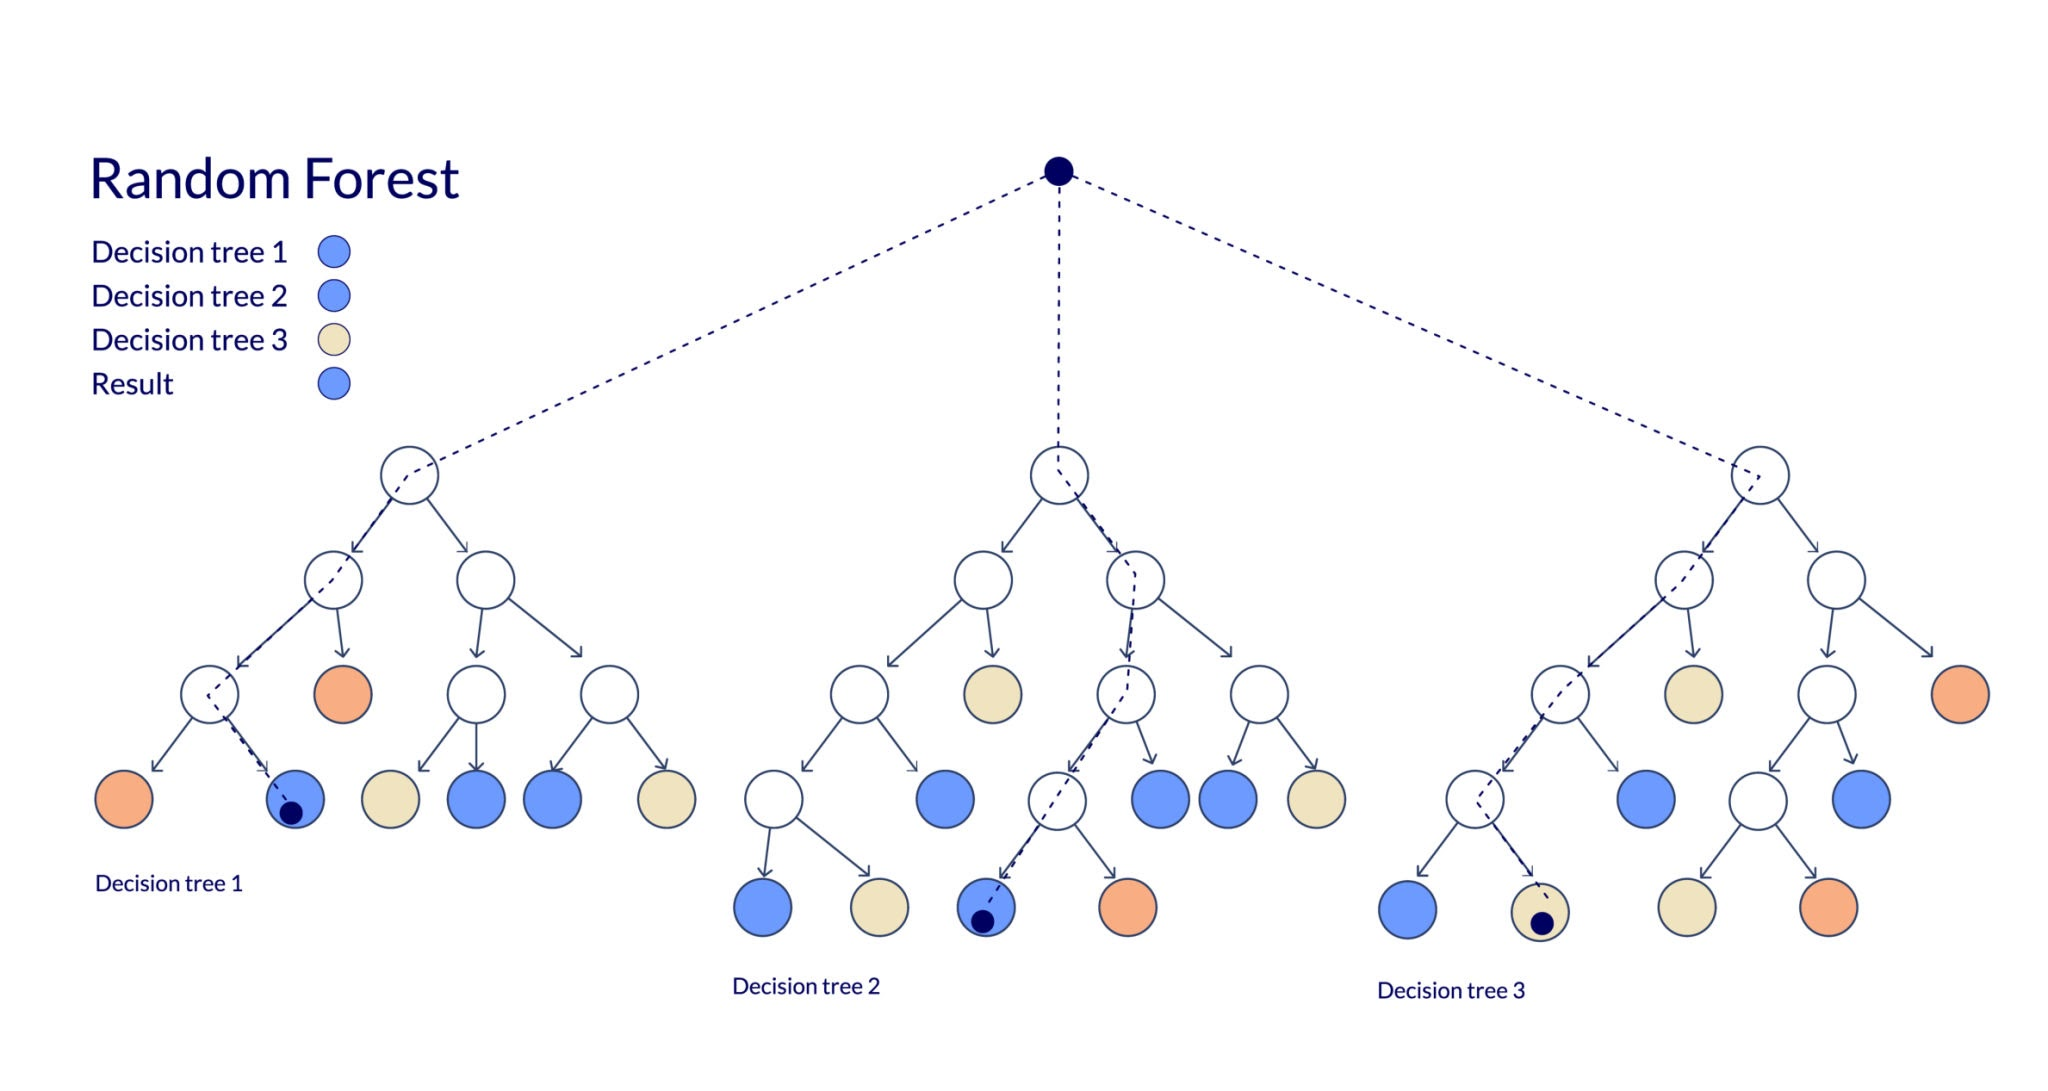

-------------------------------------------------------------------------------------------
### Phase 2: Default Performance & Cross-Validation

First, we train the model with its default settings. But we won't just run it once. We will use **Cross-Validation** immediately.

**What is Cross-Validation?** Imagine you have an exam with 100 questions.

*   **Train/Test Split:** You study questions 1-80, and take the test on 81-100. Maybe you got lucky and questions 81-100 were easy!
    
*   **Cross-Validation (5-Fold):** You split the questions into 5 chunks. You take 5 different exams, rotating which chunk is the "Test" each time.
    
    *   Exam 1: Test on Chunk A.
        
    *   Exam 2: Test on Chunk B.
        
    *   ...
        
*   **Result:** Your score is the **Average** of all 5 exams. This is a much truer measure of your intelligence.

In [ ]:
# 1. Initialize the Models (Default Settings)
# n_estimator=100 means Create 100 Trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Run Cross-Validation (The "5 Exams")
#